In [2]:
import numpy as np
import cv2 as cv
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.cluster import DBSCAN

In [60]:
df = x_reduced

In [61]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors=5).fit(df)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(df)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis=0)

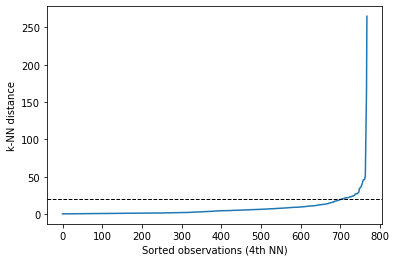

In [64]:
import matplotlib.pyplot as plt
k_dist = sort_neigh_dist[:, 4]
plt.plot(k_dist)
plt.axhline(y=20, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

In [7]:
# dataset = pd.read_csv("Downloads\\citrus.csv")
# dataset = dataset[4000:6000]
# df = dataset.drop("name",axis=1)
dataset = pd.read_csv("https://reneshbedre.github.io/assets/posts/tsne/tsne_scores.csv")
dataset = pd.read_csv("Downloads\\diabetes2.csv")
x_train = dataset.to_numpy()

In [222]:
df = dataset.drop("Outcome", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 48.1 KB


In [74]:
clusters = DBSCAN(eps=2.5, min_samples=4).fit(dataset)

In [8]:
from collections import Counter
# print((clusters.labels_).shape)
x_train = dataset.to_numpy()[:,:-1]
y = dataset.to_numpy()[:,-1]

In [57]:
x_train = x_train.T
for i in range(x_train.shape[0]):
    max_ = x_train[i].max()
    min_ = x_train[i].min()
    m = max_- min_
    x_train[i]-=min_
    x_train[i]/=m

x_train = x_train.T

In [9]:
x_train.shape

(768, 8)

In [10]:
class PCA:
    def __init__(self,n_components=1):
        self.n_components = n_components
        self.covariance=None
        self.eigen_vector = None
        self.mean = None
    def fit(self, dataset):
        if (not len(dataset.shape)==2):
            print(f"Error expected dimensions = 2 but got {len(dataset.shape)}")
            return
        else:
            d_size = dataset.shape[1]
            self.covariance = np.zeros((dataset.shape[1],dataset.shape[1]))
            self.mean = np.mean(dataset , axis = 0)
            dataset = dataset - self.mean
            # Cov (x,y) = Σ ( (xi – x) * (yi – y) / N
            r=0
            for i in dataset.T:    
                l=0
                for j in dataset.T:
                    k = i.dot(j)/(i.shape[0]-1)
                    self.covariance[r,l] = k
                    l+=1
                r+=1
        eigen_value, eigen_vector = np.linalg.eig(self.covariance)
        
        idx = np.argsort(eigen_value)[::-1]
        eigen_value, eigen_vector = eigen_value[idx], eigen_vector.T[idx]
        self.eigen_vector = eigen_vector[:self.n_components].T
            
            
    def transform(self, sample):
        sample = sample-np.mean(sample, axis=0)
        return sample.dot(self.eigen_vector)
                    
    def inverse_transform(self, sample):
        return sample.dot(self.eigen_vector.T)+self.mean
        

In [36]:
pca =PCA(5)
pca.fit(x_train)
x_reduced = pca.transform(x_train)
x_recounstructed = pca.inverse_transform(x_reduced)


In [37]:
print(x_recounstructed[:2], x_train[:2])

[[6.70957726e+00 1.47825119e+02 7.17373513e+01 3.42339638e+01
  2.22484164e-02 3.69576534e+01 5.34593122e-01 4.99383628e+01]
 [3.56651189e+00 8.47185513e+01 6.55740565e+01 2.77613208e+01
  3.79221068e-02 3.20196290e+01 4.37558079e-01 3.06662139e+01]] [[  6.    148.     72.     35.      0.     33.6     0.627  50.   ]
 [  1.     85.     66.     29.      0.     26.6     0.351  31.   ]]


# DBSCAN

In [13]:
#DBSCAN Loop
def group_1(dic, minpts, truth_):
    
    dics = []
    for idxs in tqdm(range(len(dic))):
        idx = set()
        if truth_[idxs]:
            if len(dic[idxs])>=minpts:
                truth_[idxs]=False
                for j in dic[idxs]:
#                     idx.add(j)
                    ls = group_2(dic, j, truth_)
                    for k in ls:
                        idx.add(k)
                dics.append(idx)
    return dics
    
def group_2(dic, dic_, truth_):
    
    dics = []
    
    idx = set()
    if truth_[dic_]:

        truth_[dic_]=False
        for j in dic[dic_]:
            idx.add(j)
            ls = group_2(dic, j, truth_)
            for k in ls:
                idx.add(k)
        dics.append(idx)
    else:
        return set()
    return idx

# With PCA

In [14]:
x = x_reduced.copy()

In [21]:
shape = x.shape[0]
epsilon = 15
#calc distance
distance = np.array([np.concatenate((np.sqrt(np.sum(np.power(np.subtract(x[i],x[0:i+1]),2),axis=1).astype(np.float32)), np.zeros((shape-i-1,))),axis=0) for i in tqdm(range(shape))])
distance+=distance.T

dic=[]

dex = 0
for i in tqdm(range(shape)):
    idx = np.arange(0,distance[i].shape[0],1)
    
    dic.append(np.array([l for l in idx if distance[i,l]<=epsilon]))
    

    
    

100%|██████████████████████████████████████████████████████████████████████████████| 768/768 [00:00<00:00, 3132.59it/s]


In [22]:
minpoints = 4
truth = np.full((shape, ), True, dtype=bool)
d = group_1(dic,minpoints, truth)

100%|█████████████████████████████████████████████████████████████████████████████| 768/768 [00:00<00:00, 22174.52it/s]


In [23]:
g = [np.array(list(g)) for g in d if len(g)>=minpoints]
print(len(g))
s=0
for k in g:
    print(len(k))
    s+=len(k)
print("total->", s, "noise->", x_reduced.shape[0]-s)


5
334
275
32
12
5
total-> 658 noise-> 110


In [189]:
# def class_(groups, index):
#     j = 0
#     for gr in groups:
#         if index in gr:
#             return j+1
#         j+=1
#     return 0
    
# ls = np.zeros((x_reduced.shape[0],), dtype=np.uint8)
# for i in range(x_reduced.shape[0]):
# #     print(i)
#     ls[i] = class_(g, i)
# ls = ls.reshape((-1,))
# ls.shape
# # xr = np.concatenate((x,x),axis=1)
# # xr.shape

(768,)

In [215]:
# out_=[]
# y = dataset["Outcome"].to_numpy()
# for i in range(len(g)):
#     if (y[g[i]]==0).sum()/len(g[i])>0.5:
#         out_.append(0)
#     else:
#         out_.append(1)
# out_
# r=3
# (y[g[r]]==1).sum()

10

In [190]:
# xr=pd.DataFrame(x,columns=["0","1","2"])

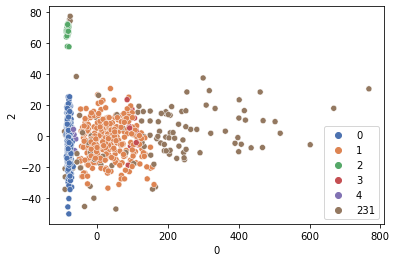

In [154]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# p = sns.scatterplot(data=xr, x="0", y="2", hue=ls, legend="full", palette="deep")
# plt.show()

# Without PCA

In [24]:
x = x_train.copy()
x.shape

(768, 8)

In [31]:
shape = x.shape[0]
epsilon = 20
#calc distance
distance = np.array([np.concatenate((np.sqrt(np.sum(np.power(np.subtract(x[i],x[0:i+1]),2),axis=1).astype(np.float32)), np.zeros((shape-i-1,))),axis=0) for i in tqdm(range(shape))])
distance+=distance.T

dic=[]

dex = 0
for i in tqdm(range(shape)):
    idx = np.arange(0,distance[i].shape[0],1)
    
    dic.append(np.array([l for l in idx if distance[i,l]<=epsilon]))
    
    

    
    

100%|██████████████████████████████████████████████████████████████████████████████| 768/768 [00:00<00:00, 1746.75it/s]


In [32]:
minpoints = 4
truth = np.full((shape, ), True, dtype=bool)
d = group_1(dic,minpoints, truth)

100%|█████████████████████████████████████████████████████████████████████████████| 768/768 [00:00<00:00, 42076.72it/s]


In [33]:
g = [np.array(list(g)) for g in d if len(g)>=minpoints]
print(len(g))
s=0
for k in g:
    print(len(k))
    s+=len(k)
print("total->", s, "noise->", x_train.shape[0]-s)

6
309
232
22
7
6
7
total-> 583 noise-> 185


In [55]:
# def class_(groups, index):
#     j = 0
#     for gr in groups:
#         if index in gr:
#             return j
#         j+=1
#     return 999
    
# ls = np.zeros((x_train.shape[0],), dtype=np.uint8)
# for i in range(x_train.shape[0]):
#     ls[i] = class_(g, i)
# ls = ls.reshape((-1,))
# ls.shape

(768,)